In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

In [2]:
data_path = '.\P96-Section-2-Emotion-AI\Emotion+AI+Dataset\Emotion AI Dataset\icml_face_data.csv'
facial_expression_df = pd.read_csv(data_path)

In [3]:
facial_expression_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


In [4]:
facial_expression_df.columns = [ col.strip() for col in facial_expression_df.columns]

In [5]:
def string2array(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [6]:
facial_expression_df['pixels'] = facial_expression_df['pixels'].apply(lambda x : string2array(x))

In [7]:
def resize(x):
    img = x.reshape(48, 48)
    return cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)

In [8]:
facial_expression_df['pixels'] = facial_expression_df['pixels'].apply(lambda x : resize(x))

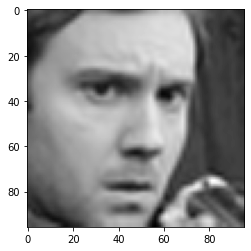

In [44]:
plt.imshow(facial_expression_df['pixels'][0], cmap='gray')

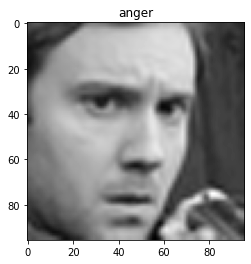

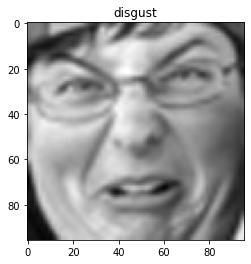

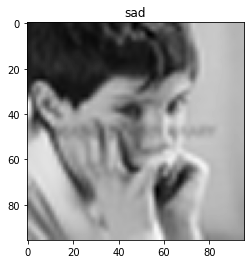

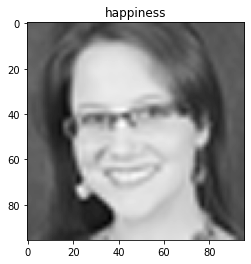

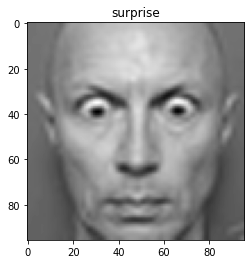

In [45]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}
emotions = set(facial_expression_df['emotion'])

for i in emotions:
    data = facial_expression_df[facial_expression_df['emotion']==i][:1]
    img = data['pixels'].item()
    img = img.reshape(96, 96)
    plt.figure()
    plt.title(label_to_text[i])
    plt.imshow(img, cmap = 'gray')

In [46]:
facial_expression_df['emotion'].dtype

dtype('int64')

<AxesSubplot:ylabel='emotion'>

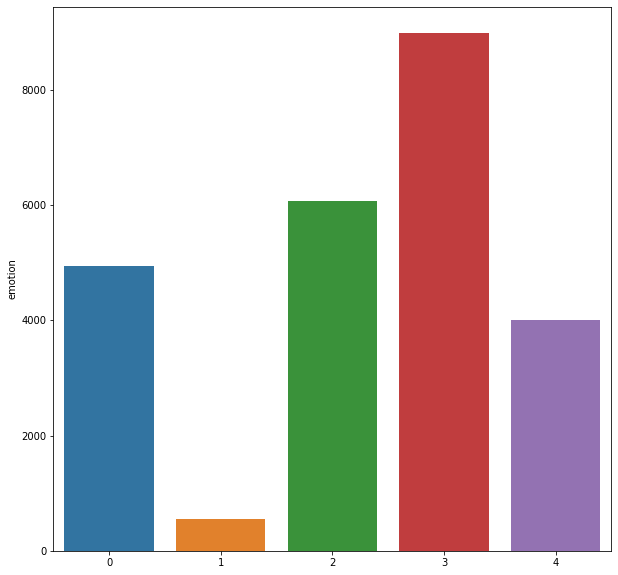

In [47]:
plt.figure(figsize = (10,10))
sns.barplot(x = facial_expression_df.emotion.value_counts().index, y = facial_expression_df.emotion.value_counts())

In [52]:
# Data Preparation
X = facial_expression_df['pixels']
y = to_categorical(facial_expression_df['emotion'])

In [53]:
X = np.stack(X, axis=0)
X = X.reshape(24568, 96, 96, 1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

In [55]:
# image pre-processing, normalize image
X_train = X_train/255
X_val   = X_val /255
X_test  = X_test/255

In [57]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [59]:
print(X_test.shape, y_test.shape)

(1229, 96, 96, 1) (1229, 5)


In [60]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


In [61]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest"
)

In [62]:
def res_block(X, filter, stage):

    # Convolutional_block
    X_copy = X

    f1 , f2, f3 = filter

    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


    # Short path
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 1
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 2
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [68]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 102, 102, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [69]:
# train the network
model_2_emotion.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
checkpointer = ModelCheckpoint(filepath="FacialExpression_weights.hdf5", verbose=1, save_best_only=True)

In [71]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val),
                             steps_per_epoch=len(X_train)//32, epochs=20, callbacks=[checkpointer, earlystopping]
                             )

Epoch 1/20
690/690 [==============================] - 48s 68ms/step - loss: 1.2198 - accuracy: 0.5088 - val_loss: 1.1906 - val_accuracy: 0.5399

Epoch 00001: val_loss improved from inf to 1.19058, saving model to FacialExpression_weights.hdf5
Epoch 2/20
690/690 [==============================] - 48s 69ms/step - loss: 0.9024 - accuracy: 0.6434 - val_loss: 1.2511 - val_accuracy: 0.4544

Epoch 00002: val_loss did not improve from 1.19058
Epoch 3/20
690/690 [==============================] - 50s 73ms/step - loss: 0.8085 - accuracy: 0.6856 - val_loss: 0.8242 - val_accuracy: 0.6767

Epoch 00003: val_loss improved from 1.19058 to 0.82418, saving model to FacialExpression_weights.hdf5
Epoch 4/20
690/690 [==============================] - 51s 74ms/step - loss: 0.7561 - accuracy: 0.7093 - val_loss: 0.8389 - val_accuracy: 0.6629

Epoch 00004: val_loss did not improve from 0.82418
Epoch 5/20
690/690 [==============================] - 51s 74ms/step - loss: 0.7181 - accuracy: 0.7234 - val_loss: 0.82

In [74]:
# save the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json", "w") as json_file:
    json_file.write(model_json)

In [80]:
# load the model
with open('FacialExpression-model.json', 'r') as json_file :
    json_savedModel = json_file.read()
    
# load the model architecture and weight
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('FacialExpression_weights.hdf5')
model_2_emotion.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
# test the model
score = model_2_emotion.evaluate(X_test, y_test)
print('Test accuracy : {}'.format(score[1]))

39/39 [==============================] - 9s 213ms/step - loss: 0.5700 - accuracy: 0.7950
Test accuracy : 0.7949552536010742
